In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# GAN: What, why and how

In [ ]:
''' There are 10 types of models

1) Discriminative models
- classify or characterize existing data.
- We take existing data, and then the model makes some kind of characterization or judgement about the data.

2) Generative models
- create new samples.
- You don't start with exsting data.
- Instead, the model seeks to create data out of thin air. So the model is going to make up data that don't actually exist in the real world.

- But both of these models are similar, which is that they both have to figure out how to represent the concept of a cat.
- So somehow both of these models understand that there is this abstract representation of a cat
  that is embedded in the patterns of weights and non-linearities across the different nodes of this network.

* Generative adversarial networks
- It's generative because it's generating new data and adversarial because GANs are actually two models that are competing
  against each other.
- One model is called the generative model and the other is called the discriminator model.
- At the beginning of training, the generator model starts with random weights, and the model thinks that this is a cat,
- But then the discriminator model comes along and says. "Nope, that is definitely not a cat."
- The generator model doesn't like to be wrong, so it's going to change its weights to try to produce an output that
  discriminator will say yes to.

- The big picture is there is this constant battle, this competition between one model that's trying to generate fake data that looks real,
  and another model that's trying to discriminate between real data and fake data.
1) Generative model
2) Discriminator model

* GAN applications
- Combine two categories to increase training set.
- Super-resolution upscaling.
- Personalized medical devices.
- Evil (e.g., deep fakes).
- Learning from private data without privacy concerns (learn from data, then delete original data).

* Current issues with GANs
- Sensitive to model architecture and features.
- Evaluating GANs is mostly qualitative.
- Difficulties with translation from lab to real-world applications.
- Evil (deep fakes)
- Ignore everything above! (except for ethical issues...)

'''

# Linear GAN with MNIST

In [ ]:
''' The goal of our network
- Create a generator network that can create digits out of noise.
- We will use a "linear GAN" (network has only fully-connected linear layers).
- Provide skeleton code for later GAN projects in this section (and for your future as a GANer!).

* Our models
1) Generator network
64 (Leaky relu) -> 256 (Leaky relu) -> 256 (tanh) -> 784

2) Discriminator network
784 (Leaky relu) -> 256 (Leaky relu) -> 256 (Sigmoid) -> 1
'''

## Import the data

In [ ]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# don't need the labels heree
data = data[:,1:]

# normalize the data to a range of [-1 1] (b/c tahh output)
dataNorm = data / np.max(data)
dataNorm = 2*dataNorm - 1

# convert to tensor
data_tensor = torch.tensor(dataNorm).float()

# no dataloaders!
batchsize = 100

## Create classes for the discriminator and generator

In [ ]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)

dnet = discriminatorNet()
y = dnet(torch.randn(10, 784))
y

tensor([[0.5027],
        [0.5264],
        [0.4908],
        [0.5013],
        [0.4907],
        [0.5282],
        [0.5218],
        [0.5100],
        [0.5034],
        [0.5041]], grad_fn=<SigmoidBackward0>)

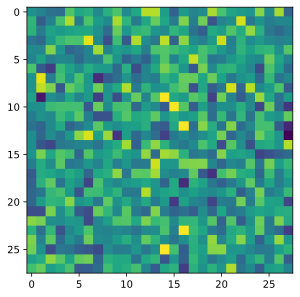

In [ ]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.tanh(x)

gnet = generatorNet()
y = gnet(torch.randn(10, 64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

## Train the models!

In [ ]:
# loss function (same for both phases of training)
lossfunc = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [ ]:
# this cell takes ~3 mins with 50k epochs
num_epochs = 50000

losses = np.zeros((num_epochs, 2))
disDecs = np.zeros((num_epochs, 2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):

    # create minibatches of REAL and FAKE images
    rand_idx = torch.randint(data_tensor.shape[0], (batchsize,))
    real_images = data_tensor[rand_idx, :].to(device)
    fake_images = gnet( torch.randn(batchsize, 64).to(device) ) # output of generator

    # labels used for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)

    ### ------------------ Train the discriminator ----------------------- ###

    # forward pass and loss for REAL pictures
    pred_real = dnet(real_images)                             # REAL images into discriminator
    d_loss_real = lossfunc(pred_real, real_labels)     # all labels are 1

    # forward pass and loss for FAKE pictures
    pred_fake = dnet(fake_images)                            # FAKE images into discriminator
    d_loss_fake = lossfunc(pred_fake, fake_labels)   # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi, 0] = d_loss.item()
    disDecs[epochi, 0] = torch.mean((pred_real>.5).float()).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### ------------------ Train the generator ----------------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize, 64).to(device) )
    pred_fake = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfunc(pred_fake, real_labels)
    losses[epochi, 1] = g_loss.item()
    disDecs[epochi, 1] = torch.mean((pred_fake>.5).float()).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # print out a status message
    if (epochi+1)%500==0:
        msg = f'Finished epoch {epochi+1} / {num_epochs}'
        sys.stdout.write('\r' + msg)

Finished epoch 50000 / 50000

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discriminator', 'Generator'])
# ax[0].set_xlim([4000,6000])

ax[1].plot(losses[::5, 0], losses[::5, 1], 'k.', alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()

## Let's see some fake digits!

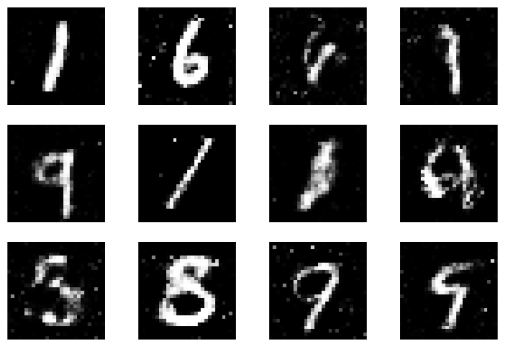

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig, axs = plt.subplots(3,4,figsize=(9,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().view(28,28), cmap='gray')
    ax.axis('off')

plt.show()

# Linear GAN with FMNIST

In [ ]:
''' The Job
* Train on 3 image classes (keep the full dataset):
  - Trouser, sneaker, pullover
  - Trouser, sneaker, sandal
* Use dataloader and batches (train 50k batches).
* Smooth the loss function.
'''

In [ ]:
''' Lessons to learn about biases in GANs
- Over-represented or prominent images(categories) can form powerful attractors in the model space ("mode collapse").
  Noise will naturally move towards those attractor states.
- Unbalanced classes can also bias the model towards one class (sneaker ~~ sandal).
- Qualitatively, performance seemed worse than with digits.
  Perhaps the 2-layer linear network lacks sufficient depth to represent both the coarse and fine detail of FMNIST...

'''

## Import the data

In [ ]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Resize(64),
    T.Normalize(.5, .5),
])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

# list the categories
print(dataset.classes)

# pick three categories (leave one line uncommented)
classes2keep = ['Trouser', 'Sneaker', 'Pullover']
# classes2keep = ['Trouser', 'Sneaker', 'Sandal']

# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
    class_idx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat((images2use, torch.where(dataset.targets==class_idx)[0]), 0).type(torch.long)
    print(f'Added class {classes2keep[i]} (index {class_idx})')

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index 1)
Added class Sneaker (index 7)
Added class Pullover (index 2)


In [ ]:
# now select just those images

# transform to dataloaders
batchsize = 100
sampler = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset, sampler=sampler, batch_size=batchsize, drop_last=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


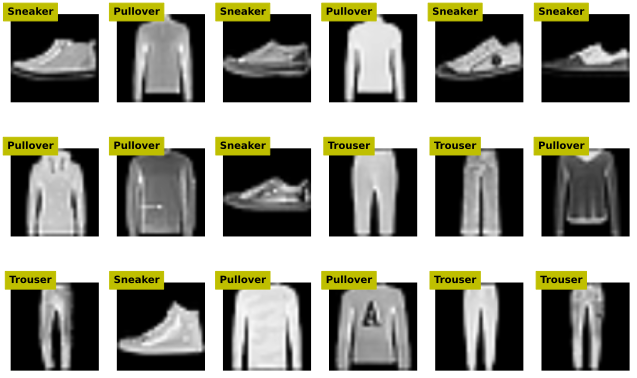

In [ ]:
# view some images
# inspect a few random images

X, y = next(iter(data_loader))

fig, axs = plt.subplots(3,6,figsize=(9,6))

for (i, ax) in enumerate(axs.flatten()):

    # extract that image
    pic = torch.squeeze(X.data[i])
    pic = pic / 2 + .5

    # and its label
    label = dataset.classes[y[i]]

    # and show!
    ax.imshow(pic, cmap='gray')
    ax.text(14,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create classes for the discriminator and generator

In [ ]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

        # batchnorm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        return torch.sigmoid(self.conv5(x)).view(-1, 1)

dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


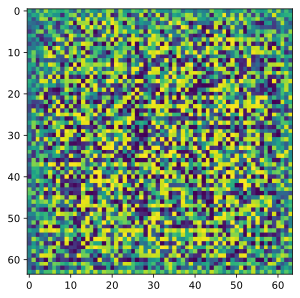

In [ ]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)

        # batchnorm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)


    def forward(self, x):
        x = F.relu( self.bn1(self.conv1(x)) )
        x = F.relu( self.bn2(self.conv2(x)) )
        x = F.relu( self.bn3(self.conv3(x)) )
        x = F.relu( self.bn4(self.conv4(x)) )
        x = torch.tanh( self.conv5(x) )
        return x

gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

## Train the models!

In [ ]:
lossfunc = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

# number of epochs (expressed in number of batches)
num_epochs = int(2500/len(data_loader))

losses = []
disDecs = []

for epochi in range(num_epochs):

    for data, _ in data_loader:

        # send data to GPU
        data = data.to(device)

        # create labels for real and fake images
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)

        ### ----------------- Train the discriminator -------------------------- ###

        # forward pass and loss for REAL pictures
        pred_real = dnet(data)                                                          # output of discriminator
        d_loss_real = lossfunc(pred_real, real_labels)                     # all labels are 1

        # forward pass and loss for FAKE pictures
        fake_data = torch.randn(batchsize, 100, 1, 1).to(device)     # random numbers to seed the generator
        fake_images = gnet(fake_data)                                            # output of generator
        pred_fake = dnet(fake_images)                                            # pass through discriminator
        d_loss_fake = lossfunc(pred_fake, fake_labels)                   # all labels are 0

        # collect loss (using combined losses)
        d_loss = d_loss_real + d_loss_fake

        # backprop
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ### ----------------- Train the generator -------------------------- ###

        # create fake images and compute loss
        fake_images = gnet( torch.randn(batchsize, 100, 1, 1).to(device) )
        pred_fake = dnet(fake_images)

        # compute loss
        g_loss = lossfunc(pred_fake, real_labels)

        # backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # collect losses and discriminator decisions
        losses.append([d_loss.item(), g_loss.item()])

        d1 = torch.mean((pred_real>.5).float()).item()
        d2 = torch.mean((pred_fake>.5).float()).item()
        disDecs.append([d1, d2])

    # print out a status message
    msg = f'Finished epoch {epochi+1} / {num_epochs}'
    sys.stdout.write('\r' + msg)

# convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array(disDecs)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finished epoch 13 / 13

In [ ]:
# create 1D smoothing filter
def smooth(x, k=15):
    return np.convolve(x, np.ones(k)/k, mode='same')

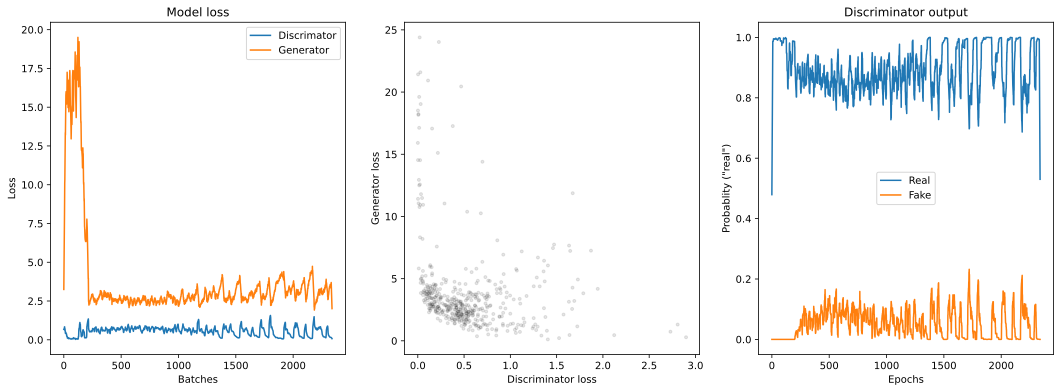

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,2300])
# ax[0].set_ylim([-.5,6])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

## Let's see some fake fashion!

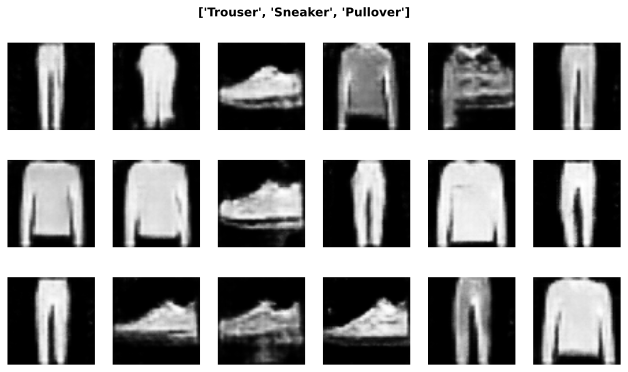

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize, 100, 1, 1).to(device) ).cpu()

# and visualize...
fig, axs = plt.subplots(3,6,figsize=(11,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i, :,].detach().squeeze(), cmap='gray')
    ax.axis('off')

plt.suptitle(classes2keep, y=.95, fontweight='bold')
plt.show()

In [ ]:
# I've mentioned before that GANs can be quite sensitive to subtle changes in model architecture. Try running the code
#    again with exactly one change: Set the Adam 'betas' parameters to their default values (simply remove that argument
#    from the code. How much of an impact does this have on the results? More generally, these sensitivities can be
#    frustrating when trying to build new models; the best thing to do is search the web for similar kinds of models and
#    be inspired by their decisision (but don't assume that a model is good just because it's on the web!).

# CNN GAN with Gaussians

## Create the data

In [ ]:
nImages = 3000
imgSize = 64

x = np.linspace(-4,4,imgSize)
X, Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(nImages, 1, imgSize, imgSize)

for i in range(nImages):

    # create the gaussian with random centers
    ro = 2 * np.random.randn(2) # ro = random offset
    width = np.random.rand()/.6 + 1.8 # random width
    G = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2 ) / (2*width**2) )

    # and add noise
    G += np.random.randn(imgSize, imgSize)/5

    # add to the tensor
    images[i, :,:,:] = torch.Tensor(G).view(1,imgSize, imgSize)

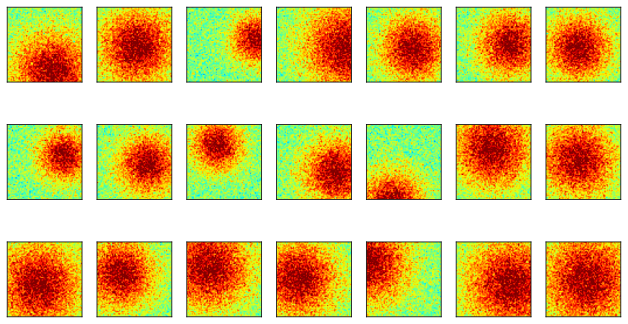

In [ ]:
# visualize some images
fig, axs = plt.subplots(3,7,figsize=(11,6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze( images[whichpic, :,:] )
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create classes for the discriminator and generator

In [ ]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 0, bias=False)

        # batchnorm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, x):
        # print(x.shape)
        x = F.leaky_relu( self.conv1(x), .2 )
        # print(x.shape)
        x = F.leaky_relu( self.conv2(x), .2 )
        # print(x.shape)
        x = self.bn2(x)
        x = F.leaky_relu( self.conv3(x), .2 )
        # print(x.shape)
        x = self.bn3(x)
        x = F.leaky_relu( self.conv4(x), .2 )
        # print(x.shape)
        x = self.bn4(x)
        return torch.sigmoid( self.conv5(x) ).view(-1, 1)

dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

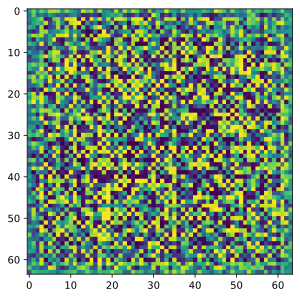

In [ ]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolutio layers
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)

        # batchnorm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        # print(x.shape)
        x = F.relu( self.bn1(self.conv1(x)) )
        # print(x.shape)
        x = F.relu( self.bn2(self.conv2(x)) )
        # print(x.shape)
        x = F.relu( self.bn3(self.conv3(x)) )
        # print(x.shape)
        x = F.relu( self.bn4(self.conv4(x)) )
        # print(x.shape)
        x = torch.tanh( self.conv5(x) )
        # print(x.shape)
        return x

gnet = generatorNet()
y = gnet(torch.randn(10, 100, 1, 1))
# print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

## Train the models!

In [ ]:
lossfunc = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

# training parameters and initializations
num_epochs = 1500
batchsize=86
losses = []
disDecs = []

for epochi in range(num_epochs):

    # create a minibatch from randomly selected images
    r_idx = torch.randint(images.shape[0], (batchsize,))
    data = images[r_idx, :].to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)

    ### ------------- Train the discriminator --------------- ###

    # forward pass and loss for REAL pictures
    pred_real = dnet(data)
    d_loss_real = lossfunc(pred_real, real_labels)

    # forward pass and loss for FAKE pictures
    fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
    fake_images = gnet(fake_data)
    pred_fake = dnet(fake_images)
    d_loss_fake = lossfunc(pred_fake, fake_labels)

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### ------------- Train the generator --------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize, 100, 1, 1).to(device) )
    pred_fake = dnet(fake_images)

    # compute loss
    g_loss = lossfunc(pred_fake, real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # collect losses and discriminator decisions
    losses.append([d_loss.item(), g_loss.item()])

    d1 = torch.mean((pred_real>.5).float()).item()
    d2 = torch.mean((pred_fake>.5).float()).item()
    disDecs.append([d1, d2])

    # print out a status message
    if (epochi+1)%50==0:
        msg = f'Finished epoch {epochi+1} / {num_epochs}'
        sys.stdout.write('\r' + msg)

# convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 1500 / 1500

In [ ]:
# create a 1D smoothing filter
def smooth(x, k=15):
    return np.convolve(x, np.ones(k)/k, mode='same')

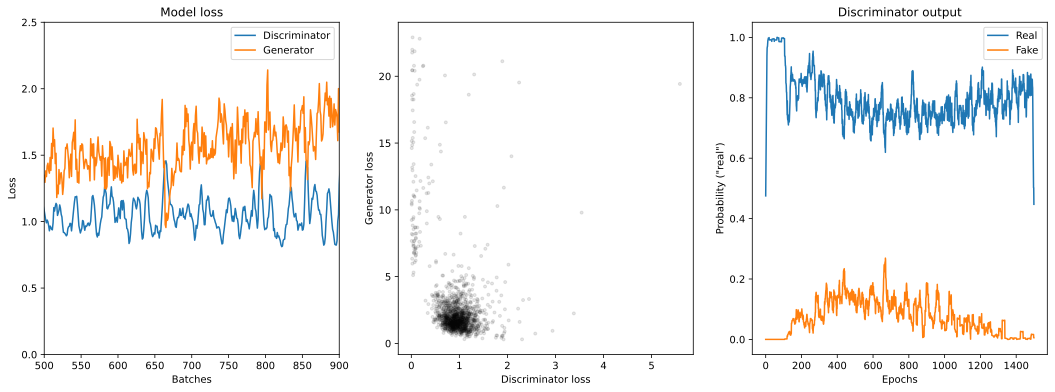

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(smooth(losses[:,0], 5))
ax[0].plot(smooth(losses[:,1], 5))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discriminator', 'Generator'])
ax[0].set_xlim([500, 900])
ax[0].set_ylim([0, 2.5])

ax[1].plot(losses[:,0], losses[:,1], 'k.', alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()

## Let's see some generated Gaussians!

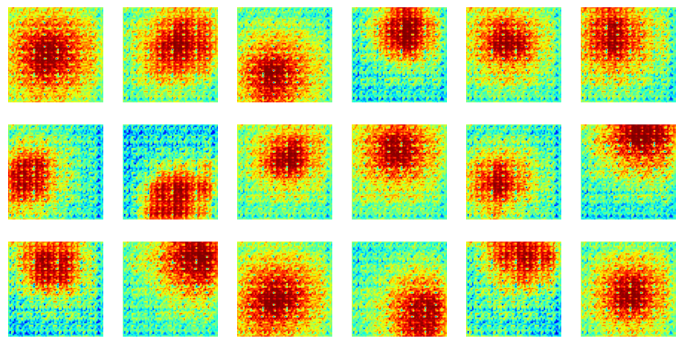

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,].detach().squeeze(),cmap='jet')
  ax.axis('off')

plt.show()

# Gaussians with fewer layers

## Create the data

In [3]:
nImages = 3000
imgSize = 64

x = np.linspace(-4,4,imgSize)
X, Y = np.meshgrid(x,x)

# initialize tensors containing images and labels
images = torch.zeros(nImages, 1, imgSize, imgSize)

for i in range(nImages):

    # create the gaussian with random centers
    ro = 2*np.random.randn(2)
    width = np.random.rand()/.6 + 1.8
    G = np.exp( -((X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

    # and add noise
    G += np.random.randn(imgSize, imgSize)/5

    # add to the tensor
    images[i, :,:,:] = torch.Tensor(G).view(1, imgSize, imgSize)

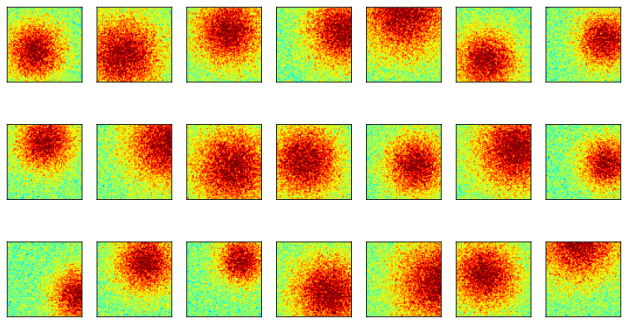

In [4]:
# visualize some images
fig, axs = plt.subplots(3,7, figsize=(11,6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create classes for the discriminator and generator

In [6]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.Conv2d(1,64,4,3,0, bias=False)
        self.conv2 = nn.Conv2d(64,128,4,3,0,bias=False)
        self.conv3 = nn.Conv2d(128, 1, 4, 3, 0, bias=False)

        # batchnorm
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), .2)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        return torch.sigmoid(self.conv3(x)).view(-1, 1)

dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

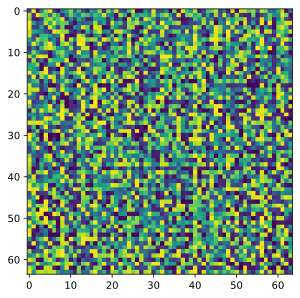

In [9]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.ConvTranspose2d(100, 256, 4, 4, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(256, 128, 4, 4, 0, bias=False)
        self.conv3 = nn.ConvTranspose2d(128, 1, 4, 4, 0, bias=False)

        # batchnorm
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = torch.tanh(self.conv3(x))
        return x

gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
y.shape

plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

## Train the models!

In [11]:
lossfunc = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

# training parameters and initializations
num_epochs = 10500
batchsize=86
losses = []
disDecs = [] # discriminator decisions

for epochi in range(num_epochs):

    # create a minibatch from randomly selected images
    r_idx = torch.randint(images.shape[0], (batchsize,))
    data = images[r_idx, :].to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize, 1).to(device)
    fake_labels = torch.zeros(batchsize, 1).to(device)

    ### --------------------- Train the discriminator -------------------------- ###

    # forward pass and loss for REAL pictures
    pred_real = dnet(data)
    d_loss_real = lossfunc(pred_real, real_labels)

    # forward pass and loss for FAKE pictures
    fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
    fake_images = gnet(fake_data)
    pred_fake = dnet(fake_images)
    d_loss_fake = lossfunc(pred_fake, fake_labels)

    # collect loss
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ### --------------------- Train the generator -------------------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize, 100, 1, 1).to(device) )
    pred_fake = dnet(fake_images)

    # compute loss
    g_loss = lossfunc(pred_fake, real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # collect losses and discriminator decisions
    losses.append([d_loss.item(), g_loss.item()])

    d1 = torch.mean((pred_real>.5).float()).item()
    d2 = torch.mean((pred_fake>.5).float()).item()
    disDecs.append([d1, d2])

    # print out a status message
    if (epochi + 1)% 50 == 0:
        msg = f'Finished {epochi+1} / {num_epochs}'
        sys.stdout.write('\r' + msg)

# convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array(disDecs)

Finished 10500 / 10500

In [12]:
# create a 1D smoothing filter
def smooth(x, k=15):
    return np.convolve(x, np.ones(k)/k, mode='same')

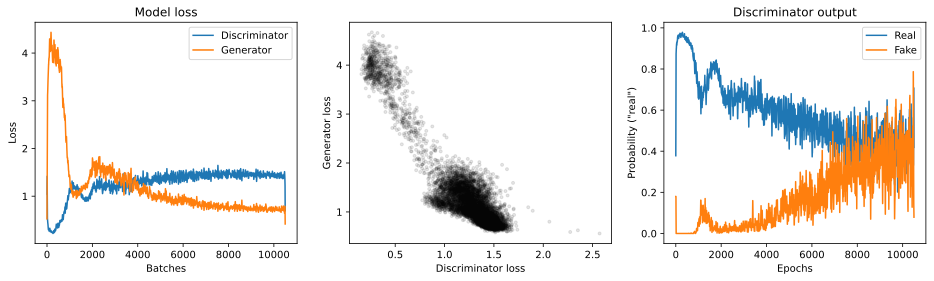

In [13]:
fig, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discriminator', 'Generator'])
# ax[0].set_xlim([500, 900])

ax[1].plot(losses[:,0], losses[:,1], 'k.', alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real', 'Fake'])

plt.show()

## Let's see some generated Gaussians!

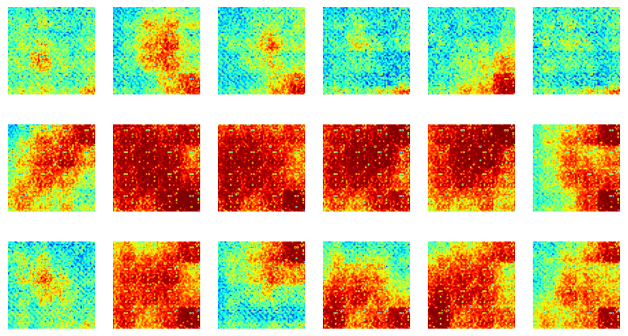

In [14]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(batchsize, 100, 1, 1).to(device)).cpu()

# and visualize...
fig, axs = plt.subplots(3,6,figsize=(11,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i].detach().squeeze(), cmap='jet')
    ax.axis('off')

plt.show()

In [ ]:
'''
* The CNN GANs need sufficient complexity, even for simple images.
'''

# CNN GAN with FMNIST

In [ ]:
'''
* CNN GANs work better than linear GANs for image generation!
* A good GAN architecture can be very adaptive to new images with different characteristics.
'''

## Import the data

In [16]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Resize(64),
    T.Normalize(.5, .5)
])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=transform)

# list of categories
print(dataset.classes)

# pick three categories
classes2keep = ['Trouser', 'Sneaker', 'Pullover']

# find the corresponding data indices
images2use = torch.Tensor()
for i in range(len(classes2keep)):
    class_idx = dataset.classes.index(classes2keep[i])
    images2use = torch.cat( (images2use, torch.where(dataset.targets==class_idx)[0]), 0 ).type(torch.long)
    print(f'Added class {classes2keep[i]} (index: {class_idx})')

# now select just those images

# transform to dataloaders
batchsize=100
sampler = torch.utils.data.sampler.SubsetRandomSampler(images2use)
data_loader = DataLoader(dataset, sampler=sampler, batch_size=batchsize, drop_last=True)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Added class Trouser (index: 1)
Added class Sneaker (index: 7)
Added class Pullover (index: 2)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


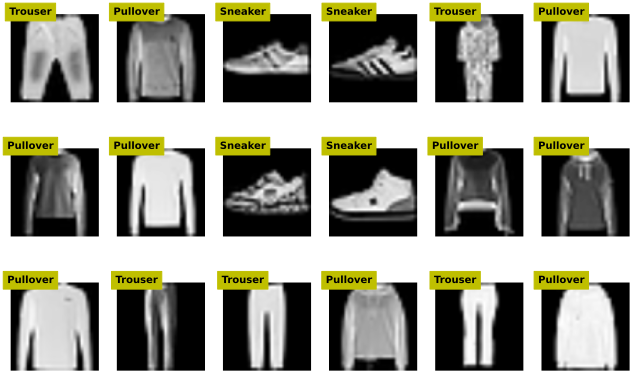

In [17]:
# view some images
# inspect a few random images

X, y = next(iter(data_loader))

fig, axs = plt.subplots(3,6,figsize=(9,6))

for (i, ax) in enumerate(axs.flatten()):

    pic = torch.squeeze(X.data[i])
    pic = pic/2 + .5

    label = dataset.classes[y[i]]

    ax.imshow(pic, cmap='gray')
    ax.text(14,0,label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create classes for the discriminator and generator

In [21]:
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.Conv2d(1,64,4,2,1,bias=False)
        self.conv2 = nn.Conv2d(64,128,4,2,1,bias=False)
        self.conv3 = nn.Conv2d(128,256,4,2,1,bias=False)
        self.conv4 = nn.Conv2d(256,512,4,2,1,bias=False)
        self.conv5 = nn.Conv2d(512,1,4,1,0,bias=False)

        # batchnorm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = F.leaky_relu( self.conv1(x), .2 )
        x = F.leaky_relu( self.conv2(x), .2 )
        x = self.bn2(x)
        x = F.leaky_relu( self.conv3(x), .2 )
        x = self.bn3(x)
        x = F.leaky_relu( self.conv4(x), .2 )
        x = self.bn4(x)
        return torch.sigmoid( self.conv5(x) ).view(-1, 1)

dnet = discriminatorNet()
y = dnet(torch.randn(10,1,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])


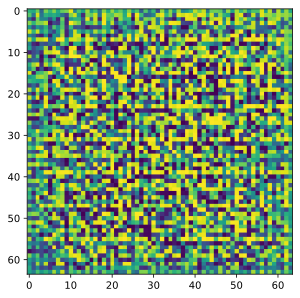

In [22]:
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False)

        # batchnorm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu( self.bn1(self.conv1(x)) )
        x = F.relu( self.bn2(self.conv2(x)) )
        x = F.relu( self.bn3(self.conv3(x)) )
        x = F.relu( self.bn4(self.conv4(x)) )
        x = torch.tanh( self.conv5(x) )
        return x

gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
plt.imshow(y[0,:,:,:].squeeze().detach().numpy());

## Train the models!

In [24]:
lossfunc = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

# number of epochs (expressed in number of batches)
num_epochs = int(2500/len(data_loader))

losses = []
disDecs = []

for epochi in range(num_epochs):

    for data, _ in data_loader:

        data = data.to(device)

        # create labels for real and fake images
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)

        ### --------------- Train the discriminator ----------------- ###

        # forward pass and loss for REAL pictures
        pred_real = dnet(data)
        d_loss_real = lossfunc(pred_real, real_labels)

        # forward pass and loss for FAKE pictures
        fake_data = torch.randn(batchsize, 100, 1, 1).to(device)
        fake_images = gnet(fake_data)
        pred_fake = dnet(fake_images)
        d_loss_fake = lossfunc(pred_fake, fake_labels)

        # collect loss (using combined losses)
        d_loss = d_loss_real + d_loss_fake

        # backprop
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ### --------------- Train the generator ----------------- ###

        # create fake images and compute loss
        fake_images = gnet( torch.randn(batchsize, 100, 1, 1).to(device) )
        pred_fake = dnet(fake_images)

        # compute loss
        g_loss = lossfunc(pred_fake, real_labels)

        # backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # collect losses and discriminator decisions
        losses.append([d_loss.item(), g_loss.item()])

        d1 = torch.mean((pred_real>.5).float())
        d2 = torch.mean((pred_fake>.5).float())
        disDecs.append([d1.item(), d2.item()])

        # print out a status message
        msg = f'Finished epoch{epochi+1} / {num_epochs}'
        sys.stdout.write('\r' + msg)

# convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array(disDecs)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finished epoch13 / 13

In [25]:
# create a 1D smoothing filter
def smooth(x, k=15):
    return np.convolve(x, np.ones(k)/k, mode='same')

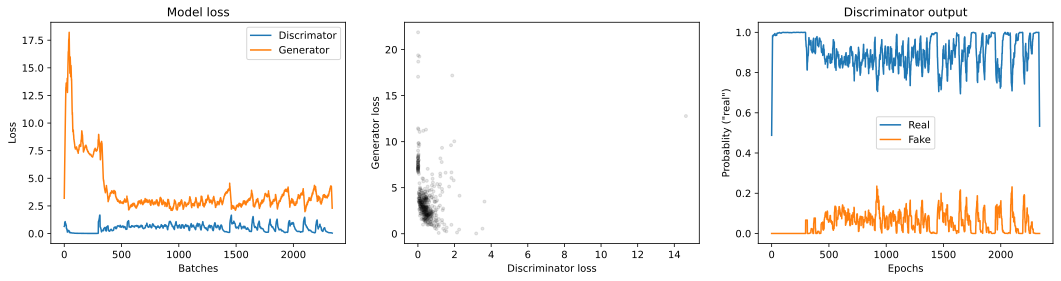

In [26]:
fig,ax = plt.subplots(1,3,figsize=(18,4))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([500,2300])
# ax[0].set_ylim([-.5,6])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

## Let's see some fake fashion!

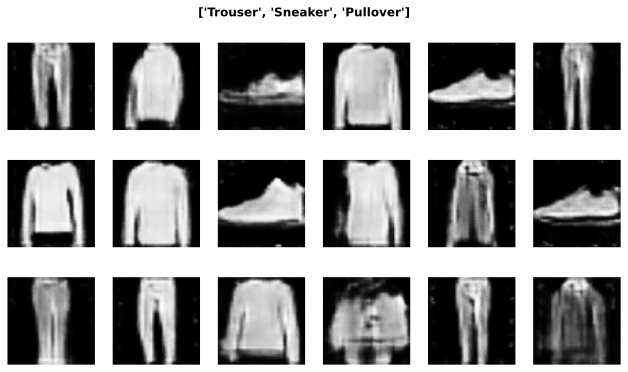

In [27]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(batchsize, 100, 1, 1).to(device)).cpu()

# and visualize...
fig, axs = plt.subplots(3,6, figsize=(11,6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,:,].detach().squeeze(), cmap='gray')
    ax.axis('off')

plt.suptitle(classes2keep, y=.95, fontweight='bold')
plt.show()

# CNN GAN with CIFAR

## Import the data

In [28]:
# transformations
transform = T.Compose([
    T.ToTensor(),
    T.Resize(64),
    T.Normalize([.5,.5,.5],[.5,.5,.5])
])

# import the data and simultaneously apply the transform
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)

# transform to dataloaders
batchsize=32
data_loader = DataLoader(dataset, batch_size=batchsize, shuffle=True, drop_last=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 97178381.12it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


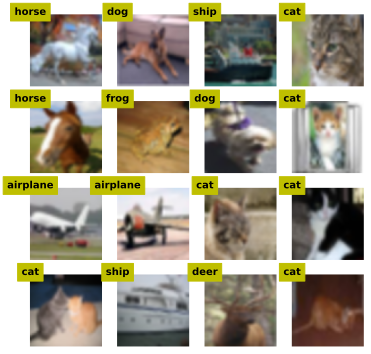

In [30]:
# inspect a few random images
X, y = next(iter(data_loader))

fig, axs = plt.subplots(4,4, figsize=(6,6))

for (i, ax) in enumerate(axs.flatten()):

    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic/2 + .5

    label = dataset.classes[y[i]]

    ax.imshow(pic)
    ax.text(0,0,label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

# plt.tight_layout()
plt.show()

## Create classes for the discriminator and generator

In [31]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
    self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
    self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
    self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
    self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

    # batchnorm
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(256)
    self.bn4 = nn.BatchNorm2d(512)

  def forward(self,x):
    x = F.leaky_relu( self.conv1(x) ,.2)
    x = F.leaky_relu( self.conv2(x) ,.2)
    x = self.bn2(x)
    x = F.leaky_relu( self.conv3(x) ,.2)
    x = self.bn3(x)
    x = F.leaky_relu( self.conv4(x) ,.2)
    x = self.bn4(x)
    return torch.sigmoid( self.conv5(x) ).view(-1,1)


dnet = discriminatorNet()
y = dnet(torch.randn(10,3,64,64))
y.shape

torch.Size([10, 1])

torch.Size([10, 3, 64, 64])


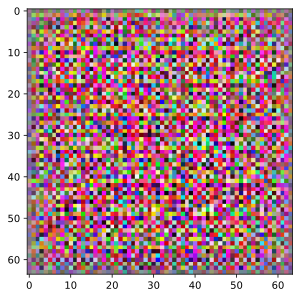

In [32]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    # convolution layers
    self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
    self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
    self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
    self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
    self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

    # batchnorm
    self.bn1 = nn.BatchNorm2d(512)
    self.bn2 = nn.BatchNorm2d(256)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d( 64)


  def forward(self,x):
    x = F.relu( self.bn1(self.conv1(x)) )
    x = F.relu( self.bn2(self.conv2(x)) )
    x = F.relu( self.bn3(self.conv3(x)) )
    x = F.relu( self.bn4(self.conv4(x)) )
    x = torch.tanh( self.conv5(x) )
    return x


gnet = generatorNet()
y = gnet(torch.randn(10,100,1,1))
print(y.shape)
pic = y[0,:,:,:].squeeze().detach().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
plt.imshow(pic);

## Train the models!

In [35]:
lossfunc = nn.BCELoss()

dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0002, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0002, betas=(.5, .999))

len(data_loader)

1562

In [ ]:
num_epochs = 40

losses = []
disDecs = []

for epochi in range(num_epochs):

  for data,_ in data_loader:

    # send data to GPU
    data = data.to(device)

    # create labels for real and fake images
    real_labels = torch.ones(batchsize,1).to(device)
    fake_labels = torch.zeros(batchsize,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)                     # output of discriminator
    d_loss_real = lossfunc(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_data   = torch.randn(batchsize,100,1,1).to(device) # random numbers to seed the generator
    fake_images = gnet(fake_data)                           # output of generator
    pred_fake   = dnet(fake_images)                         # pass through discriminator
    d_loss_fake = lossfunc(pred_fake,fake_labels)            # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()



    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batchsize,100,1,1).to(device) )
    pred_fake   = dnet(fake_images)

    # compute loss
    g_loss = lossfunc(pred_fake,real_labels)

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # collect losses and discriminator decisions
    losses.append([d_loss.item(),g_loss.item()])

    d1 = torch.mean((pred_real>.5).float()).detach()
    d2 = torch.mean((pred_fake>.5).float()).detach()
    disDecs.append([d1.item(), d2.item()])

  # print out a status message
  msg = f'Finished epoch {epochi+1}/{num_epochs}'
  sys.stdout.write('\r' + msg)


# convert performance from list to numpy array
losses  = np.array(losses)
disDecs = np.array(disDecs)

Finished epoch 1/40

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(smooth(losses[:,0]))
ax[0].plot(smooth(losses[:,1]))
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([1500,2000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(smooth(disDecs[:,0]))
ax[2].plot(smooth(disDecs[:,1]))
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()


## Let's see some fake pictures!

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet( torch.randn(batchsize,100,1,1).to(device) ).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  pic = fake_data[i,:,].detach().squeeze().numpy().transpose((1,2,0))
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
  ax.imshow(pic,cmap='gray')
  ax.axis('off')

plt.show()